Baseline Test MSE: 0.3714
Best Hyperparameters:
max_depth: 23
max_features: 0.37385289388819165
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 1000


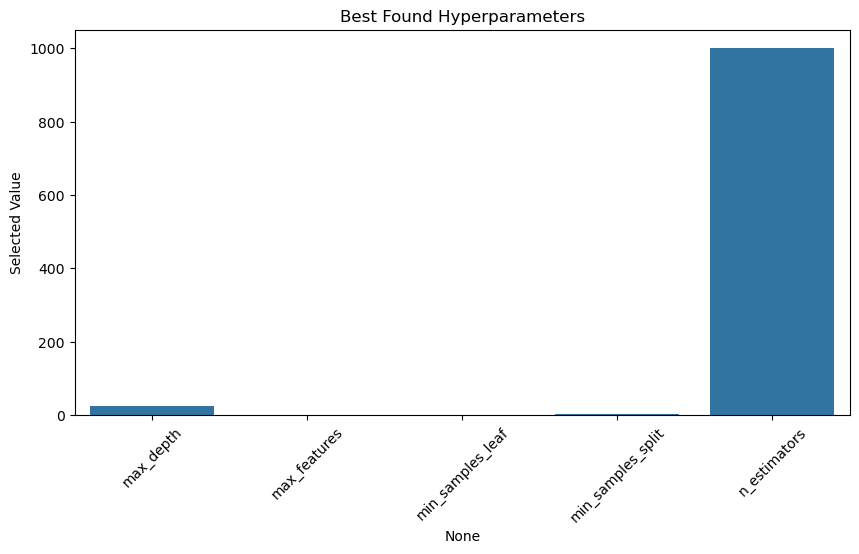

Optimized Test MSE: 0.3575


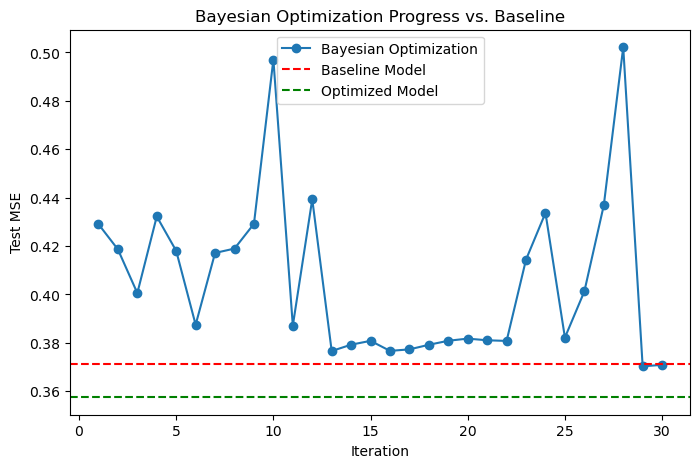

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# Load dataset
path = 'data/dataset.csv'
data = pd.read_csv(path)

# Split features and target
X = data.drop(columns=["Quality"])  # Ensure column names match
y = data["Quality"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model (Random Forest with default parameters)
baseline_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
baseline_rf.fit(X_train, y_train)
y_pred_baseline = baseline_rf.predict(X_test)
baseline_mse = mean_squared_error(y_test, y_pred_baseline)
print(f"Baseline Test MSE: {baseline_mse:.4f}")

# Define the hyperparameter search space
param_space = {
    "n_estimators": Integer(200, 1000),
    "max_depth": Integer(5, 30),
    "min_samples_split": Integer(2, 20),
    "min_samples_leaf": Integer(1, 10),
    "max_features": Real(0.1, 1.0, "uniform"),
}

# Define the model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Setup Bayesian Optimization
bayes_search = BayesSearchCV(
    rf,
    param_space,
    n_iter=30,  # Number of evaluations
    cv=5,  # Cross-validation folds
    n_jobs=-1,
    scoring="neg_mean_squared_error",  # Minimize MSE
    random_state=42,
    return_train_score=True
)

# Run Bayesian Optimization
bayes_search.fit(X_train, y_train)

# Extract best hyperparameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Visualize Hyperparameter Importance
import seaborn as sns
import matplotlib.pyplot as plt

# Convert best hyperparameters to a DataFrame for visualization
best_params_df = pd.DataFrame([best_params])

# Plot hyperparameter values
plt.figure(figsize=(10, 5))
sns.barplot(x=best_params_df.columns, y=best_params_df.values[0])
plt.xticks(rotation=45)
plt.ylabel("Selected Value")
plt.title("Best Found Hyperparameters")
plt.show()


# Evaluate the optimized model
best_rf = bayes_search.best_estimator_
y_pred_optimized = best_rf.predict(X_test)
optimized_mse = mean_squared_error(y_test, y_pred_optimized)
print(f"Optimized Test MSE: {optimized_mse:.4f}")

# Extract MSE over iterations
opt_results = bayes_search.cv_results_["mean_test_score"]
opt_results = -np.array(opt_results)  # Convert negative MSE to positive values

# Plot Optimization Progress
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(opt_results) + 1), opt_results, marker="o", linestyle="-", label="Bayesian Optimization")
plt.axhline(y=baseline_mse, color='r', linestyle="--", label="Baseline Model")
plt.axhline(y=optimized_mse, color='g', linestyle="--", label="Optimized Model")
plt.xlabel("Iteration")
plt.ylabel("Test MSE")
plt.title("Bayesian Optimization Progress vs. Baseline")
plt.legend()
plt.show()
